# Federated Analysis Simulation 3x3 model

In [1]:
import numpy as np

def aggregate_weights_median(weights_dict):
    """
    Aggregate weights layer-wise across all studies using the median.
    """
    studies = list(weights_dict.keys())
    n_layers = len([w for w in weights_dict[studies[0]] if w is not None])

    aggregated_weights = []
    for layer_idx in range(n_layers):
        # Collect all weights for this layer across studies
        layer_weights = [weights_dict[study][layer_idx] for study in studies if weights_dict[study] is not None]

        # Stack and take median across the first axis (studies)
        stacked = np.stack(layer_weights, axis=0)
        median_weight = np.median(stacked, axis=0)
        aggregated_weights.append(median_weight)

    return aggregated_weights


In [2]:
def extract_model_weights_per_study(mse_summaries):
    weights_dict = {}

    for study in mse_summaries.keys():
        model_path = f"models/{study}_model.keras"

        try:
            model = load_model(model_path)
            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [3]:
from tensorflow.keras.models import load_model
import os

def extract_model_weights_per_study(study_list, model_dir="models"):
    """
    Extract weights from saved models for each study in study_list.

    Parameters:
        study_list (list of str): List of study IDs (e.g., ["SDY569", ...])
        model_dir (str): Directory where model files are saved.

    Returns:
        dict: Mapping of study ID to its model weights.
    """
    weights_dict = {}

    for study in study_list:
        model_path = os.path.join(model_dir, f"{study}_3x3_model.keras")

        try:
            model = load_model(model_path)
            weights = model.get_weights()
            weights_dict[study] = weights
        except Exception as e:
            print(f"⚠️ Could not load model for {study}: {e}")
            weights_dict[study] = None

    return weights_dict


In [4]:
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
import os

def build_model_from_file(model_path):
    """
    Load a Keras model structure from an existing model file (without weights).
    """
    model = load_model(model_path)
    model_json = model.to_json()
    new_model = model_from_json(model_json)
    return new_model


In [5]:
def build_federated_model(aggregated_weights, reference_model_path):
    """
    Build a model with aggregated weights.
    """
    model = build_model_from_file(reference_model_path)
    model.set_weights(aggregated_weights)
    return model

In [6]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def evaluate_federated_model_3x3(federated_model, study_id):
    # Load test data
    df_test = pd.read_csv(f"test_data/{study_id}_3x3_test.csv")

    # Extract features
    X_test = df_test.iloc[:, :9].values  # full input
    X_test_reshaped = X_test.reshape((-1, 3, 3, 1))

    # Predict
    reconstructed = federated_model.predict(X_test_reshaped)
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # Evaluate first 5 columns (autoantibodies)
    ab_cols = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
    X_ab_true = X_test[:, :5]
    X_ab_pred = reconstructed_flat[:, :5]

    # Overall MSE
    mse = mean_squared_error(X_ab_true, X_ab_pred)

    # Per-antibody MSE
    per_antibody_mse = {
        ab: mean_squared_error(X_ab_true[:, i], X_ab_pred[:, i])
        for i, ab in enumerate(ab_cols)
    }
    mse_ab_median = np.median(list(per_antibody_mse.values()))
    mse_ab_iqr = np.percentile(list(per_antibody_mse.values()), 75) - \
                 np.percentile(list(per_antibody_mse.values()), 25)

    # Reconstruct DataFrames
    df_true = pd.DataFrame(X_ab_true, columns=ab_cols)
    df_pred = pd.DataFrame(X_ab_pred, columns=ab_cols)

    # Reconstruct Age_Group from one-hot encoded columns
    age_group_cols = ["8-12", "13-17", "18-30"]
    df_test["Age_Group"] = df_test[age_group_cols].idxmax(axis=1)
    
    # Reconstruct Sex from binary column
    df_test["Sex"] = df_test["Sex"].map({0: "Male", 1: "Female"})

    # Attach original demographic values
    df_true["Age_Group"] = df_test["Age_Group"]
    df_true["Sex"] = df_test["Sex"]
    df_pred["Age_Group"] = df_test["Age_Group"]
    df_pred["Sex"] = df_test["Sex"]

    # MSE by age group
    mse_by_age_group = df_true.groupby("Age_Group").apply(
        lambda g: mean_squared_error(
            g[ab_cols], df_pred.loc[g.index, ab_cols]
        )
    ).to_dict()

    mse_age_group_median = np.median(list(mse_by_age_group.values()))
    mse_age_group_iqr = np.percentile(list(mse_by_age_group.values()), 75) - \
                        np.percentile(list(mse_by_age_group.values()), 25)

    # MSE by sex
    mse_by_sex = df_true.groupby("Sex").apply(
        lambda g: mean_squared_error(
            g[ab_cols], df_pred.loc[g.index, ab_cols]
        )
    ).to_dict()

    mse_sex_median = np.median(list(mse_by_sex.values()))
    mse_sex_iqr = np.percentile(list(mse_by_sex.values()), 75) - \
                  np.percentile(list(mse_by_sex.values()), 25)

    return {
        "study": study_id,
        "mse": mse,
        "mse_ab_median": mse_ab_median,
        "mse_ab_iqr": mse_ab_iqr,
        "per_antibody_mse": per_antibody_mse,
        "mse_by_age_group": mse_by_age_group,
        "mse_by_sex": mse_by_sex,
        "mse_age_group_median": mse_age_group_median,
        "mse_age_group_iqr": mse_age_group_iqr,
        "mse_sex_median": mse_sex_median,
        "mse_sex_iqr": mse_sex_iqr,
        "N_test": len(X_test),
        "y_true": X_ab_true,
        "y_pred": X_ab_pred,
    }


In [7]:
# ========== STEP 0: Set working directory (for running locally on laptop) =========
os.getcwd()
os.chdir("/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody")
os.getcwd()

'/Users/adeslatt/Scitechcon Dropbox/Anne DeslattesMays/projects/oadr-autoantibody'

In [8]:
study_list = ["SDY569", "SDY1625", "SDY524", "SDY797", "SDY1737"]
weights_dict = extract_model_weights_per_study(study_list)

In [9]:
# 1. Aggregate the weights
aggregated_weights = aggregate_weights_median(weights_dict)

# 2. Build federated model using any of the saved models as architecture reference 3x3 model
#    any of the 3x3 models can be used - it is just for the shape
reference_model_path = "models/SDY569_3x3_model.keras"
federated_model_3x3 = build_federated_model(aggregated_weights, reference_model_path)



In [10]:
print("Study list:", study_list)


Study list: ['SDY569', 'SDY1625', 'SDY524', 'SDY797', 'SDY1737']


In [11]:
federated_results_3x3 = {}

for study_id in study_list:
    print(f"Evaluating federated model on 3x3 {study_id}...")
    result = evaluate_federated_model_3x3(federated_model_3x3, study_id)
    print(f"Result keys for {study_id}:", list(result.keys()))
    federated_results_3x3[study_id] = result


Evaluating federated model on 3x3 SDY569...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Result keys for SDY569: ['study', 'mse', 'mse_ab_median', 'mse_ab_iqr', 'per_antibody_mse', 'mse_by_age_group', 'mse_by_sex', 'mse_age_group_median', 'mse_age_group_iqr', 'mse_sex_median', 'mse_sex_iqr', 'N_test', 'y_true', 'y_pred']
Evaluating federated model on 3x3 SDY1625...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Result keys for SDY1625: ['study', 'mse', 'mse_ab_median', 'mse_ab_iqr', 'per_antibody_mse', 'mse_by_age_group', 'mse_by_sex', 'mse_age_group_median', 'mse_age_group_iqr', 'mse_sex_median', 'mse_sex_iqr', 'N_test', 'y_true', 'y_pred']
Evaluating federated model on 3x3 SDY524...
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Result keys for SDY524: ['study', 'mse', 'mse_ab_median', 'mse_ab_iqr', 'per_antibody_mse', 'mse_by_age_group', 'mse_by_sex', 'mse_age_group_median', 'mse_age_group_iqr', 'mse_sex_median', 'mse_sex_iqr', 'N_test', 'y_true', 'y_pred']
Evaluating federated model on 3x3 SDY797...
1/1 ━━━

/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/2227028475.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/2227028475.py:63: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193

In [12]:
import pickle

# Load mse_summaries from file
with open("data/mse_summaries_3x3.pkl", "rb") as f:
    mse_summaries_3x3 = pickle.load(f)

# Confirm structure
print(mse_summaries_3x3.keys())


dict_keys(['SDY569', 'SDY1625', 'SDY524', 'SDY797', 'SDY1737'])


In [13]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

def augment_local_mse_summary(summary):
    ab_cols = summary["antibody_labels"]
    X_test = summary["X_test"]
    X_pred = summary["reconstructed"][:, :5]  # only antibody part
    age_groups = summary["Age_Group"]
    sex = summary["Sex"]

    # Rebuild dataframes
    df_true = pd.DataFrame(X_test, columns=ab_cols)
    df_pred = pd.DataFrame(X_pred, columns=ab_cols)
    df_true["Age_Group"] = age_groups
    df_pred["Age_Group"] = age_groups
    df_true["Sex"] = sex
    df_pred["Sex"] = sex

    # MSE by age group
    mse_by_age_group = df_true.groupby("Age_Group").apply(
        lambda g: mean_squared_error(
            g[ab_cols], df_pred.loc[g.index, ab_cols]
        )
    ).to_dict()

    mse_age_group_median = np.median(list(mse_by_age_group.values()))
    mse_age_group_iqr = np.percentile(list(mse_by_age_group.values()), 75) - \
                        np.percentile(list(mse_by_age_group.values()), 25)

    # MSE by sex
    mse_by_sex = df_true.groupby("Sex").apply(
        lambda g: mean_squared_error(
            g[ab_cols], df_pred.loc[g.index, ab_cols]
        )
    ).to_dict()

    mse_sex_median = np.median(list(mse_by_sex.values()))
    mse_sex_iqr = np.percentile(list(mse_by_sex.values()), 75) - \
                  np.percentile(list(mse_by_sex.values()), 25)

    # Update the summary dict
    summary.update({
        "mse_by_age_group": mse_by_age_group,
        "mse_age_group_median": mse_age_group_median,
        "mse_age_group_iqr": mse_age_group_iqr,
        "mse_by_sex": mse_by_sex,
        "mse_sex_median": mse_sex_median,
        "mse_sex_iqr": mse_sex_iqr,
    })

    return summary


In [14]:
for study in mse_summaries_3x3:
    mse_summaries_3x3[study] = augment_local_mse_summary(mse_summaries_3x3[study])


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/4049341339.py:21: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/4049341339.py:32: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193

In [15]:
import matplotlib.pyplot as plt
import numpy as np

# Studies
study_names = list(mse_summaries_3x3.keys())

# Extract local (individual) model results
local_medians = [mse_summaries_3x3[study]["mse_median"] for study in study_names]
local_iqrs = [mse_summaries_3x3[study]["mse_iqr"] for study in study_names]

# Extract federated model results
fed_medians = [federated_results_3x3[study]["mse_ab_median"] for study in study_names]
fed_iqrs = [federated_results_3x3[study]["mse_ab_iqr"] for study in study_names]


In [16]:
study_id = "SDY569"  # or any valid ID
mse_summaries_3x3[study_id]


{'mse_median': 0.0022123880615710356,
 'mse_iqr': 0.0014576558061314875,
 'per_antibody_mse': {'GAD65': 0.383785696692155,
  'IA2IC': 0.0011260258722488817,
  'MIAA': 0.003120475496075294,
  'ICA': 0.0022123880615710356,
  'ZNT8': 0.0016628196899438064},
 'X_train': array([[0.28301887, 0.48245614, 0.10526316, 0.        , 0.        ,
         0.        , 1.        , 0.        , 0.        ],
        [0.00943396, 0.63157895, 1.        , 0.        , 0.        ,
         0.        , 0.        , 1.        , 1.        ],
        [0.73584906, 0.00877193, 0.00956938, 0.        , 0.        ,
         0.        , 1.        , 0.        , 1.        ],
        [0.29528302, 0.23684211, 0.02870813, 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        ],
        [0.33962264, 0.93859649, 0.33971292, 0.        , 0.        ,
         0.        , 0.        , 1.        , 0.        ],
        [1.        , 0.00877193, 0.        , 0.        , 0.        ,
         1.        , 0.       

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def plot_comparison_medians(mse_summaries_local, mse_summaries_fed, study_list):
    metrics = [
        ("mse_ab_median", "Median MSE (Antibodies)"),
        ("mse_age_group_median", "Median MSE by Age Group"),
        ("mse_sex_median", "Median MSE by Sex")
    ]
    iqrs = [
        ("mse_ab_iqr", "Antibody IQR"),
        ("mse_age_group_iqr", "Age Group IQR"),
        ("mse_sex_iqr", "Sex IQR")
    ]

    # Map local key equivalents
    local_key_map = {
        "mse_ab_median": "mse_median",
        "mse_ab_iqr": "mse_iqr",
        "mse_age_group_median": "mse_age_group_median",
        "mse_age_group_iqr": "mse_age_group_iqr",
        "mse_sex_median": "mse_sex_median",
        "mse_sex_iqr": "mse_sex_iqr"
    }

    x = np.arange(len(study_list))
    width = 0.35

    for (metric_key, ylabel), (iqr_key, _) in zip(metrics, iqrs):
        local_metric_key = local_key_map.get(metric_key, metric_key)
        local_iqr_key = local_key_map.get(iqr_key, iqr_key)

        try:
            local_vals = [mse_summaries_local[study][local_metric_key] for study in study_list]
            fed_vals = [mse_summaries_fed[study][metric_key] for study in study_list]
            local_iqrs = [mse_summaries_local[study][local_iqr_key] for study in study_list]
            fed_iqrs = [mse_summaries_fed[study][iqr_key] for study in study_list]
        except KeyError as e:
            print(f"Missing key in summaries: {e}")
            continue

        fig, ax = plt.subplots(figsize=(10, 6))
        bars1 = ax.bar(x - width/2, local_vals, width, yerr=local_iqrs, label='Local', capsize=5)
        bars2 = ax.bar(x + width/2, fed_vals, width, yerr=fed_iqrs, label='Federated', capsize=5)

        ax.set_ylabel(ylabel)
        ax.set_title(f"{ylabel} – Local vs Federated")
        ax.set_xticks(x)
        ax.set_xticklabels(study_list, rotation=45)
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.5)
        plt.tight_layout()
        plt.show()


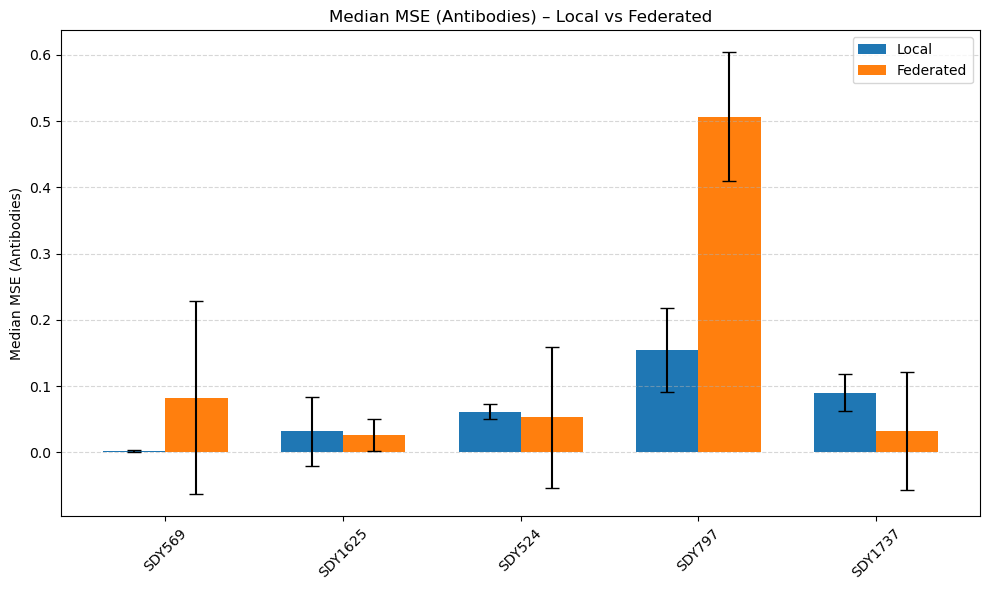

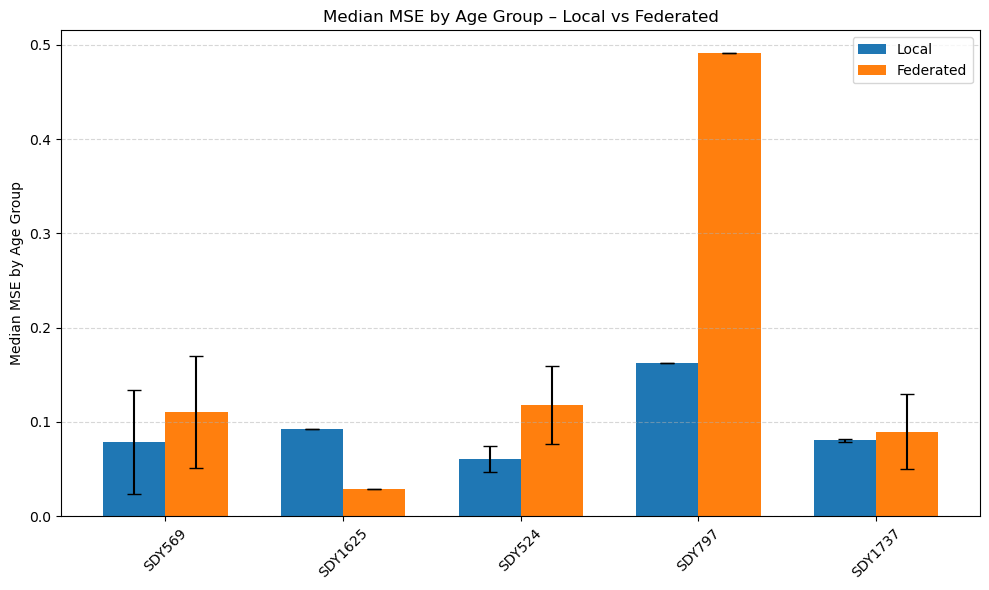

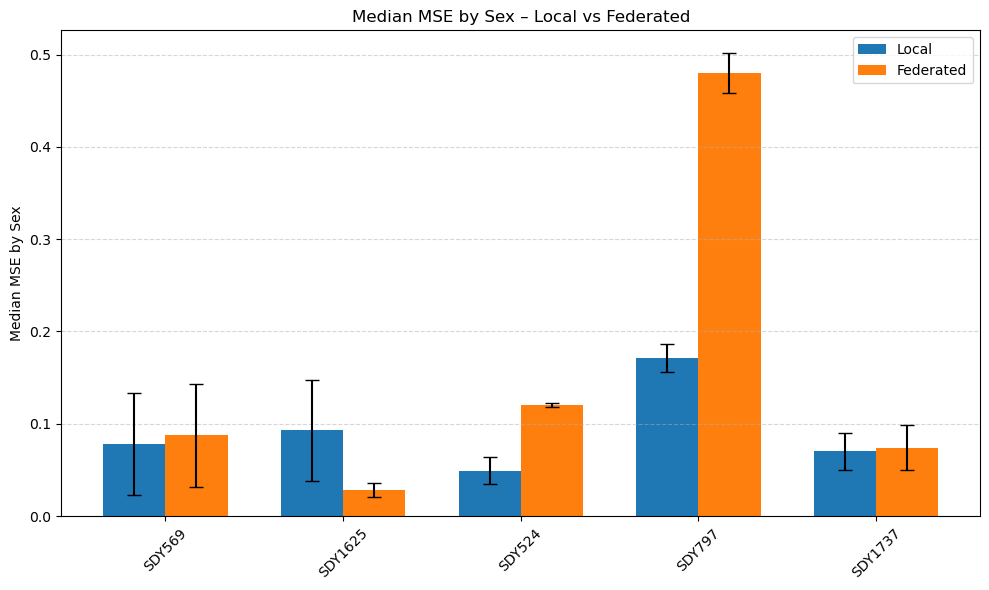

In [18]:
plot_comparison_medians(mse_summaries_3x3, federated_results_3x3, study_list)


In [19]:
def flatten_mse_results(results_dict, model_type="local"):
    records = []

    for study, res in results_dict.items():
        row = {
            "Study": study,
            "Model_Type": model_type,
            "N_test": res.get("N_test", len(res.get("X_test", []))),  # fallback
            "MSE_All": res.get("mse"),
            "MSE_AB_Median": res.get("mse_ab_median", res.get("mse_median")),
            "MSE_AB_IQR": res.get("mse_ab_iqr", res.get("mse_iqr")),
            "MSE_AgeGroup_Median": res.get("mse_age_group_median"),
            "MSE_AgeGroup_IQR": res.get("mse_age_group_iqr"),
            "MSE_Sex_Median": res.get("mse_sex_median"),
            "MSE_Sex_IQR": res.get("mse_sex_iqr"),
        }

        for ab, ab_mse in res.get("per_antibody_mse", {}).items():
            row[f"MSE_{ab}"] = ab_mse

        records.append(row)

    return pd.DataFrame(records)


In [20]:
df_local      = flatten_mse_results(mse_summaries_3x3, model_type="local")
df_federated  = flatten_mse_results(federated_results_3x3, model_type="federated")

import os

# Ensure results directory exists
os.makedirs("results", exist_ok=True)

df_combined = pd.concat([df_local, df_federated], ignore_index=True)
df_combined.to_csv("results/mse_summary_local_vs_federated.csv", index=False)
print("Saved comparison CSV: results/mse_summary_local_vs_federated.csv")

# Now save to CSV
df_combined.to_csv("results/mse_comparison_3x3.csv", index=False)
print("Saved combined MSE results to results/mse_comparison_3x3.csv")


Saved comparison CSV: results/mse_summary_local_vs_federated.csv
Saved combined MSE results to results/mse_comparison_3x3.csv


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1543469257.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined = pd.concat([df_local, df_federated], ignore_index=True)


In [21]:
# copying over the train and evaluate function from our initial notebook and will add initial weights option

In [22]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from tensorflow.keras import layers, models


def train_and_evaluate_cnn_3x3(df, study_list, study_name, epochs=50, initial_weights=None):
    print(f"\n===== Training 3x3 CNN Autoencoder for {study_name} =====")

    if isinstance(study_list, str):
        study_list = [study_list]

    # --- Filter study ---
    df_filtered = df[df["Study"].isin(study_list)].copy()
    if df_filtered.empty:
        raise ValueError(f"No data found for study {study_name}")

    # --- Normalize antibody names ---
    df_filtered["Property"] = (
        df_filtered["Property"]
        .str.upper()
        .str.replace(r"[^A-Z0-9]", "", regex=True)
    )

    # --- Pivot to wide format ---
    df_wide = df_filtered.pivot_table(
        index="Accession",
        columns="Property",
        values="Value",
        aggfunc="first"
    ).fillna(0)

    # --- Expected antibody columns ---
    antibody_labels = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
    df_wide = df_wide.reindex(columns=antibody_labels, fill_value=0)

    # --- Join demographics ---
    demo_cols = (
        df_filtered[["Accession", "Age_Group", "Sex"]]
        .drop_duplicates()
        .set_index("Accession")
    )
    df_wide = df_wide.join(demo_cols, how="left")

    # --- Scale antibody values ---
    ab_scaler = MinMaxScaler()
    X_ab = ab_scaler.fit_transform(df_wide[antibody_labels].values)

    # --- One-hot encode demographics ---
    demo_array = df_wide[["Age_Group", "Sex"]].fillna("missing").astype(str).values
    encoder = OneHotEncoder(sparse_output=False)
    X_demo = encoder.fit_transform(demo_array)

    # Pad or trim to ensure 4 demographic features
    if X_demo.shape[1] < 4:
        pad_width = 4 - X_demo.shape[1]
        X_demo = np.pad(X_demo, ((0, 0), (0, pad_width)), mode="constant")
    elif X_demo.shape[1] > 4:
        X_demo = X_demo[:, :4]

    # --- Combine into final input ---
    X_full = np.hstack([X_ab, X_demo]).astype(np.float32)
    if X_full.shape[1] != 9:
        raise ValueError(f"Expected 9 features, got {X_full.shape[1]}")

    # --- Train/test split ---
    indices = np.arange(X_full.shape[0])
    X_train, X_test, idx_train, idx_test = train_test_split(
        X_full, indices, test_size=0.5, random_state=42
    )

    # --- Reshape to 3×3 image ---
    X_train_img = X_train.reshape(-1, 3, 3, 1)
    X_test_img = X_test.reshape(-1, 3, 3, 1)

    # --- CNN Autoencoder ---
    inputs = layers.Input(shape=(3, 3, 1))
    x = layers.Conv2D(8, (3, 3), activation="relu", padding="same")(inputs)
    x = layers.Flatten()(x)
    encoded = layers.Dense(4, activation="relu")(x)
    x = layers.Dense(9, activation="relu")(encoded)
    x = layers.Reshape((3, 3, 1))(x)
    outputs = layers.Conv2D(1, (3, 3), activation="linear", padding="same")(x)
    autoencoder = models.Model(inputs, outputs)
    autoencoder.compile(optimizer="adam", loss="mse")

    if initial_weights is not None:
        autoencoder.set_weights(initial_weights)

    # --- Train ---
    autoencoder.fit(
        X_train_img, X_train_img,
        epochs=epochs,
        batch_size=8,
        validation_data=(X_test_img, X_test_img),
        verbose=0
    )

    # --- Predict ---
    reconstructed = autoencoder.predict(X_test_img)
    reconstructed_flat = reconstructed.reshape(X_test.shape)

    # --- MSE calculations ---
    per_antibody_mse = {
        ab: mean_squared_error(X_test[:, i], reconstructed_flat[:, i])
        for i, ab in enumerate(antibody_labels)
    }
    mse_ab_median = np.median(list(per_antibody_mse.values()))
    mse_ab_iqr = np.percentile(list(per_antibody_mse.values()), 75) - \
                 np.percentile(list(per_antibody_mse.values()), 25)

    # --- Age/Sex MSE analysis ---
    
    df_test = df_wide.iloc[idx_test]
    age_groups = df_test["Age_Group"].values
    sex = df_test["Sex"].values

    df_true = pd.DataFrame(X_test[:, :5], columns=antibody_labels)
    df_pred = pd.DataFrame(reconstructed_flat[:, :5], columns=antibody_labels)
    df_true["Age_Group"] = age_groups
    df_true["Sex"] = sex
    df_pred["Age_Group"] = age_groups
    df_pred["Sex"] = sex

    # MSE by age
    mse_by_age_group = df_true.groupby("Age_Group").apply(
        lambda g: mean_squared_error(g[antibody_labels], df_pred.loc[g.index, antibody_labels])
    ).to_dict()
    mse_age_group_median = np.median(list(mse_by_age_group.values()))
    mse_age_group_iqr = np.percentile(list(mse_by_age_group.values()), 75) - \
                        np.percentile(list(mse_by_age_group.values()), 25)

    # MSE by sex
    mse_by_sex = df_true.groupby("Sex").apply(
        lambda g: mean_squared_error(g[antibody_labels], df_pred.loc[g.index, antibody_labels])
    ).to_dict()
    mse_sex_median = np.median(list(mse_by_sex.values()))
    mse_sex_iqr = np.percentile(list(mse_by_sex.values()), 75) - \
                  np.percentile(list(mse_by_sex.values()), 25)

    # --- Save model ---
    model_dir = "models"
    os.makedirs(model_dir, exist_ok=True)
    model_path = os.path.join(model_dir, f"{study_name}_3x3_model.keras")
    weights_path = os.path.join(model_dir, f"{study_name}_3x3.weights.h5")
    autoencoder.save(model_path)
    autoencoder.save_weights(weights_path)
    print(f"Saved model:    {model_path}")
    print(f"Saved weights:  {weights_path}")
    print(f"MSE_AB_Median: {mse_ab_median:.6f} | IQR: {mse_ab_iqr:.6f}")

    # --- Save test data for reuse ---
    output_dir = "test_data"
    os.makedirs(output_dir, exist_ok=True)
    demo_feature_names = ["8-12", "13-17", "18-30", "Sex"]
    input_feature_names = antibody_labels + demo_feature_names
    df_test_out = pd.DataFrame(X_test, columns=input_feature_names)
    df_test_out["Accession"] = df_wide.index[idx_test]  # add it explicitly

    # --- Optional: Sanity check for alignment ---
    if True:  # Change to False to disable
        df_check = pd.DataFrame(X_test, columns=input_feature_names)
        df_check["Accession"] = df_wide.index[idx_test]
        print("Sample aligned test features:")
        display(df_check.head())
        print("Sample source data for those accessions:")
        display(df_wide.loc[df_check["Accession"]].head())
    
    csv_path = os.path.join(output_dir, f"{study_name}_3x3_test.csv")
    df_test_out.to_csv(csv_path, index=False)
    print(f"Saved test data CSV: {csv_path}")

    return {
        "mse_ab_median": mse_ab_median,
        "mse_ab_iqr": mse_ab_iqr,
        "per_antibody_mse": per_antibody_mse,
        "mse_by_age_group": mse_by_age_group,
        "mse_by_sex": mse_by_sex,
        "mse_age_group_median": mse_age_group_median,
        "mse_age_group_iqr": mse_age_group_iqr,
        "mse_sex_median": mse_sex_median,
        "mse_sex_iqr": mse_sex_iqr,
        "X_train": X_train,
        "X_test": X_test,
        "reconstructed": reconstructed_flat,
        "antibody_labels": antibody_labels,
        "Age_Group": age_groups,
        "Sex": sex
    }


In [23]:
# Reuse your current function and test data setup
retrained_results_3x3 = {}
federated_weights = federated_model_3x3.get_weights()

for study in study_list:
    print(f"\n=== Retraining on local study: {study} ===")

    result = train_and_evaluate_cnn_3x3(
        df=pd.read_csv(f"data/{study}_tidy.csv"),  # If you have per-study tidy files
        study_list=[study],
        study_name=f"{study}_RETRAINED",
        epochs=50,
        initial_weights=federated_weights  # Start from aggregated weights
    )

    retrained_results_3x3[study] = result



=== Retraining on local study: SDY569 ===

===== Training 3x3 CNN Autoencoder for SDY569_RETRAINED =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Saved model:    models/SDY569_RETRAINED_3x3_model.keras
Saved weights:  models/SDY569_RETRAINED_3x3.weights.h5
MSE_AB_Median: 0.065724 | IQR: 0.118045
Sample aligned test features:


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:129: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(


,GAD65,IA2IC,MIAA,ICA,ZNT8,8-12,13-17,18-30,Sex,Accession
0,0.858491,0.026316,0.100478,0.0,0.0,0.0,0.0,1.0,1.0,SUB151316
1,0.377358,0.008772,0.009569,0.0,0.0,0.0,1.0,0.0,0.0,SUB151308
2,0.283019,0.482456,0.105263,0.0,0.0,0.0,1.0,0.0,0.0,SUB151313
3,0.009434,0.631579,1.000000,0.0,0.0,0.0,0.0,1.0,1.0,SUB151307
4,0.735849,0.008772,0.009569,0.0,0.0,0.0,1.0,0.0,1.0,SUB151315


Sample source data for those accessions:


,GAD65,IA2IC,MIAA,ICA,ZNT8,Age_Group,Sex
Accession,,,,,,,
SUB151316,0.94,0.02,0.20,0,0,8-12,Female
SUB151308,0.43,0.00,0.01,0,0,18-30,Male
SUB151313,0.33,0.54,0.21,0,0,18-30,Male
SUB151307,0.04,0.71,2.08,0,0,8-12,Female
SUB151315,0.81,0.00,0.01,0,0,18-30,Female


Saved test data CSV: test_data/SDY569_RETRAINED_3x3_test.csv

=== Retraining on local study: SDY1625 ===

===== Training 3x3 CNN Autoencoder for SDY1625_RETRAINED =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved model:    models/SDY1625_RETRAINED_3x3_model.keras
Saved weights:  models/SDY1625_RETRAINED_3x3.weights.h5
MSE_AB_Median: 0.038569 | IQR: 0.047627
Sample aligned test features:


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:129: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(


,GAD65,IA2IC,MIAA,ICA,ZNT8,8-12,13-17,18-30,Sex,Accession
0,0.000000,0.0,0.0,0.0,0.000000,1.0,1.0,0.0,0.0,SUB209152
1,0.000000,0.0,0.0,0.0,0.001786,1.0,0.0,1.0,0.0,SUB209168
2,0.009463,0.0,0.0,0.0,0.009874,1.0,1.0,0.0,0.0,SUB209151
3,0.000000,0.0,0.0,0.0,0.000000,1.0,0.0,1.0,0.0,SUB209164
4,0.055374,1.0,0.0,0.0,0.698021,1.0,0.0,1.0,0.0,SUB209143


Sample source data for those accessions:


,GAD65,IA2IC,MIAA,ICA,ZNT8,Age_Group,Sex
Accession,,,,,,,
SUB209152,0.000,0.0,0,0,0.000,8-12,Female
SUB209168,0.000,0.0,0,0,2.410,8-12,Male
SUB209151,11.770,0.0,0,0,13.322,8-12,Female
SUB209164,0.000,0.0,0,0,0.000,8-12,Male
SUB209143,68.877,4000.0,0,0,941.802,8-12,Male


Saved test data CSV: test_data/SDY1625_RETRAINED_3x3_test.csv

=== Retraining on local study: SDY524 ===

===== Training 3x3 CNN Autoencoder for SDY524_RETRAINED =====
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/stepWARNING:tensorflow:6 out of the last 10 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x15cfba0c0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Saved model:    models/SDY524_RETRAIN

/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:129: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(


,GAD65,IA2IC,MIAA,ICA,ZNT8,8-12,13-17,18-30,Sex,Accession
0,0.025974,0.907336,0.073002,0.0,0.003953,0.0,0.0,1.0,1.0,SUB146721
1,0.849351,0.928571,0.008181,0.0,0.136759,1.0,0.0,0.0,1.0,SUB146786
2,0.352381,0.820463,0.185022,0.0,0.600791,0.0,0.0,1.0,0.0,SUB146727
3,0.020779,0.069498,1.000000,0.0,0.065613,0.0,0.0,1.0,0.0,SUB146717
4,0.811255,0.899614,0.151668,0.0,0.645059,0.0,0.0,1.0,1.0,SUB146755


Sample source data for those accessions:


,GAD65,IA2IC,MIAA,ICA,ZNT8,Age_Group,Sex
Accession,,,,,,,
SUB146721,30.0,470.0,0.116,0,-0.005,8-12,Female
SUB146786,981.0,481.0,0.013,0,0.163,13-17,Female
SUB146727,407.0,425.0,0.294,0,0.750,8-12,Male
SUB146717,24.0,36.0,1.589,0,0.073,8-12,Male
SUB146755,937.0,466.0,0.241,0,0.806,8-12,Female


Saved test data CSV: test_data/SDY524_RETRAINED_3x3_test.csv

=== Retraining on local study: SDY797 ===

===== Training 3x3 CNN Autoencoder for SDY797_RETRAINED =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved model:    models/SDY797_RETRAINED_3x3_model.keras
Saved weights:  models/SDY797_RETRAINED_3x3.weights.h5
MSE_AB_Median: 0.158358 | IQR: 0.047081
Sample aligned test features:


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:129: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(


,GAD65,IA2IC,MIAA,ICA,ZNT8,8-12,13-17,18-30,Sex,Accession
0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,SUB168903
1,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,SUB168935
2,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,SUB168937
3,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,SUB168934
4,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,SUB168907


Sample source data for those accessions:


,GAD65,IA2IC,MIAA,ICA,ZNT8,Age_Group,Sex
Accession,,,,,,,
SUB168903,0.0,1.0,1.0,0.0,1.0,8-12,Male
SUB168935,1.0,0.0,1.0,1.0,0.0,8-12,Male
SUB168937,1.0,1.0,1.0,0.0,1.0,8-12,Male
SUB168934,0.0,1.0,1.0,1.0,0.0,8-12,Female
SUB168907,1.0,0.0,0.0,1.0,1.0,8-12,Male


Saved test data CSV: test_data/SDY797_RETRAINED_3x3_test.csv

=== Retraining on local study: SDY1737 ===

===== Training 3x3 CNN Autoencoder for SDY1737_RETRAINED =====
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved model:    models/SDY1737_RETRAINED_3x3_model.keras
Saved weights:  models/SDY1737_RETRAINED_3x3.weights.h5
MSE_AB_Median: 0.071916 | IQR: 0.046896
Sample aligned test features:


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:129: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_age_group = df_true.groupby("Age_Group").apply(
/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/1849205255.py:137: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mse_by_sex = df_true.groupby("Sex").apply(


,GAD65,IA2IC,MIAA,ICA,ZNT8,8-12,13-17,18-30,Sex,Accession
0,0.599092,0.000000,0.009047,0.0,0.059028,1.0,0.0,0.0,0.0,SUB228868
1,0.004539,0.002755,0.529576,0.0,0.011285,0.0,0.0,1.0,0.0,SUB228869
2,0.287443,0.000000,0.005567,0.0,0.009549,1.0,0.0,0.0,0.0,SUB228873
3,0.111952,0.779614,0.011830,0.0,0.000000,0.0,0.0,1.0,0.0,SUB228882
4,0.086233,0.774105,0.008351,0.0,0.080729,0.0,1.0,0.0,0.0,SUB228881


Sample source data for those accessions:


,GAD65,IA2IC,MIAA,ICA,ZNT8,Age_Group,Sex
Accession,,,,,,,
SUB228868,396.0,0.0,0.013,0,0.058,13-17,Female
SUB228869,3.0,1.0,0.761,0,0.003,8-12,Female
SUB228873,190.0,0.0,0.008,0,0.001,13-17,Male
SUB228882,74.0,283.0,0.017,0,-0.010,8-12,Female
SUB228881,57.0,281.0,0.012,0,0.083,18-30,Male


Saved test data CSV: test_data/SDY1737_RETRAINED_3x3_test.csv


In [24]:
# lets look at each of the antibodies individually
def flatten_per_antibody_mse(all_results_dict, model_type):
    """
    Converts per-antibody MSEs into a long-form DataFrame for comparison.

    Parameters:
        all_results_dict (dict): Dictionary with structure {study_id: result_dict}
        model_type (str): "local", "federated", or "retrained"

    Returns:
        pd.DataFrame with columns: Study, Model_Type, Antibody, MSE
    """
    records = []

    for study, res in all_results_dict.items():
        per_ab_mse = res.get("per_antibody_mse", {})
        for ab, mse in per_ab_mse.items():
            records.append({
                "Study": study,
                "Model_Type": model_type,
                "Antibody": ab,
                "MSE": mse
            })

    return pd.DataFrame(records)


In [25]:
df_ab_local = flatten_per_antibody_mse(mse_summaries_3x3, model_type="local")
df_ab_fed   = flatten_per_antibody_mse(federated_results_3x3, model_type="federated")
df_ab_re    = flatten_per_antibody_mse(retrained_results_3x3, model_type="retrained")

df_ab_combined = pd.concat([df_ab_local, df_ab_fed, df_ab_re], ignore_index=True)
df_ab_combined.to_csv("results/per_antibody_mse_3x3.csv", index=False)
print("Saved per-antibody MSEs to results/per_antibody_mse_3x3.csv")


Saved per-antibody MSEs to results/per_antibody_mse_3x3.csv


In [26]:
df_ab_local


,Study,Model_Type,Antibody,MSE
0,SDY569,local,GAD65,0.383786
1,SDY569,local,IA2IC,0.001126
2,SDY569,local,MIAA,0.003120
3,SDY569,local,ICA,0.002212
4,SDY569,local,ZNT8,0.001663
5,SDY1625,local,GAD65,0.018312
6,SDY1625,local,IA2IC,0.336040
7,SDY1625,local,MIAA,0.031500
8,SDY1625,local,ICA,0.007718
9,SDY1625,local,ZNT8,0.070437


In [27]:
def compute_per_sample_ab_errors(y_true, y_pred, ab_labels):
    """
    Given true and predicted (n_samples x 5), compute per-sample squared error for each antibody.
    
    Returns:
        dict: {antibody: list of squared errors}
    """
    errors = {}
    for i, ab in enumerate(ab_labels):
        squared_errors = (y_true[:, i] - y_pred[:, i]) ** 2
        errors[ab] = squared_errors
    return errors


In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model

def get_model_path(study_id, model_type):
    if model_type == "local":
        return f"models/{study_id}_3x3_model.keras"
    elif model_type == "federated":
        return "models/federated_3x3_model.keras"
    elif model_type == "retrained":
        return f"models/{study_id}_RETRAINED_3x3_model.keras"
    else:
        raise ValueError(f"Unknown model type: {model_type}")

def compute_ab_median_and_iqr_per_study(study_list, model_types=["local", "federated", "retrained"]):
    all_rows = []
    antibody_labels = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]

    for study_id in study_list:
        df_test = pd.read_csv(f"test_data/{study_id}_3x3_test.csv")
        X_test = df_test.iloc[:, :9].values
        X_test_reshaped = X_test.reshape((-1, 3, 3, 1))
        X_ab_true = X_test[:, :5]

        for model_type in model_types:
            model_path = get_model_path(study_id, model_type)

            try:
                model = load_model(model_path)
                reconstructed = model.predict(X_test_reshaped)
                X_ab_pred = reconstructed.reshape(X_test.shape)[:, :5]
            except Exception as e:
                print(f"Skipping {study_id} ({model_type}) — model not found or error: {e}")
                continue

            # Per-antibody MSE
            ab_mse = [
                mean_squared_error(X_ab_true[:, i], X_ab_pred[:, i])
                for i in range(len(antibody_labels))
            ]

            # Median and IQR
            mse_median = np.median(ab_mse)
            mse_iqr = np.percentile(ab_mse, 75) - np.percentile(ab_mse, 25)

            for i, ab in enumerate(antibody_labels):
                all_rows.append({
                    "Study": study_id,
                    "Model_Type": model_type,
                    "Antibody": ab,
                    "MSE": ab_mse[i],
                    "MSE_Median_5AB": mse_median,
                    "MSE_IQR_5AB": mse_iqr
                })

    return pd.DataFrame(all_rows)


In [29]:
df_ab_iqr = compute_ab_median_and_iqr_per_study(study_list)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_per_antibody_medians_with_iqr(df_ab_iqr):
    # Aggregate to get per-antibody median + IQR by model type (across studies)
    summary = (
        df_ab_iqr
        .groupby(["Model_Type", "Antibody"])
        .agg(
            mse_median=("MSE", "median"),
            mse_iqr=("MSE", lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        )
        .reset_index()
    )

    # Plot
    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=summary,
        x="Antibody",
        y="mse_median",
        hue="Model_Type",
        errorbar=None,
        palette="Set2"
    )

    # Add error bars (IQRs)
    for i, row in summary.iterrows():
        x = list(summary["Antibody"].unique()).index(row["Antibody"])
        offset = {"local": -0.25, "federated": 0.0, "retrained": 0.25}[row["Model_Type"]]
        ax.errorbar(
            x + offset,
            row["mse_median"],
            yerr=row["mse_iqr"],
            fmt='none',
            ecolor='black',
            capsize=4
        )

    plt.title("Per-Antibody Median MSE with IQR Across Studies (3×3 Layout)")
    plt.ylabel("Median MSE")
    plt.xlabel("Antibody")
    plt.legend(title="Model Type")
    plt.tight_layout()
    plt.show()


In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_per_antibody_medians_with_iqr(df_ab_iqr):
    # Group by Model_Type and Antibody across all studies
    summary = (
        df_ab_iqr
        .groupby(["Model_Type", "Antibody"])
        .agg(
            mse_median=("MSE", "median"),
            mse_iqr=("MSE", lambda x: np.percentile(x, 75) - np.percentile(x, 25))
        )
        .reset_index()
    )

    plt.figure(figsize=(12, 6))
    ax = sns.barplot(
        data=summary,
        x="Antibody",
        y="mse_median",
        hue="Model_Type",
        palette="Set2",
        errorbar=None
    )

    # Add IQR error bars manually
    antibody_order = summary["Antibody"].unique()
    offsets = {"local": -0.25, "federated": 0, "retrained": 0.25}
    for i, row in summary.iterrows():
        x = list(antibody_order).index(row["Antibody"])
        offset = offsets.get(row["Model_Type"], 0)
        ax.errorbar(
            x + offset,
            row["mse_median"],
            yerr=row["mse_iqr"],
            fmt="none",
            ecolor="black",
            capsize=4,
            linewidth=1
        )

    ax.set_ylabel("Median MSE")
    ax.set_title("Per-Antibody MSE Comparison with IQR (3×3 input layout)")
    plt.tight_layout()
    plt.show()



In [32]:
df_ab_iqr = compute_ab_median_and_iqr_per_study(study_list)
df_ab_iqr.to_csv("results/per_antibody_mse_with_iqr.csv", index=False)
print("Saved with IQR to results/per_antibody_mse_with_iqr.csv")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Saved with IQR to results/per_antibody_mse_with_iqr.csv


In [33]:
import matplotlib.pyplot as plt

def plot_per_ab_mse_with_shared_iqr(df, ymax=None):
    antibody_labels = ["GAD65", "IA2IC", "MIAA", "ICA", "ZNT8"]
    model_order = ["local", "federated", "retrained"]
    model_colors = {"local": "#999999", "federated": "#377eb8", "retrained": "#4daf4a"}

    for study in df["Study"].unique():
        df_study = df[df["Study"] == study]

        plt.figure(figsize=(10, 6))
        ax = plt.gca()

        bar_width = 0.25
        x = np.arange(len(antibody_labels))

        for i, model in enumerate(model_order):
            df_model = df_study[df_study["Model_Type"] == model]

            mse_vals = df_model["MSE"].values
            iqr_vals = df_model["MSE_IQR_5AB"].values  # one per model/study
            shared_iqr = iqr_vals[0] if len(iqr_vals) > 0 else 0

            x_pos = x + i * bar_width

            ax.bar(
                x_pos,
                mse_vals,
                width=bar_width,
                color=model_colors[model],
                label=model.capitalize(),
                yerr=[shared_iqr] * len(mse_vals),
                capsize=4
            )

        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(antibody_labels)
        ax.set_ylabel("MSE")
        ax.set_title(f"Per-Antibody MSE with Shared IQR — {study}")
        ax.legend()
        if ymax:
            ax.set_ylim(0, ymax)
        plt.tight_layout()
        plt.show()


In [34]:
# Determine a global max for y-axis from df_combined
ymax = df_combined[[
    "MSE_AB_Median", 
    "MSE_AB_IQR", 
    "MSE_AgeGroup_Median", 
    "MSE_AgeGroup_IQR", 
    "MSE_Sex_Median", 
    "MSE_Sex_IQR"
]].max().max()

# Pad slightly for visualization
ymax = round(ymax * 1.1, 4)
print("Shared Y-axis max:", ymax)


Shared Y-axis max: 0.5569


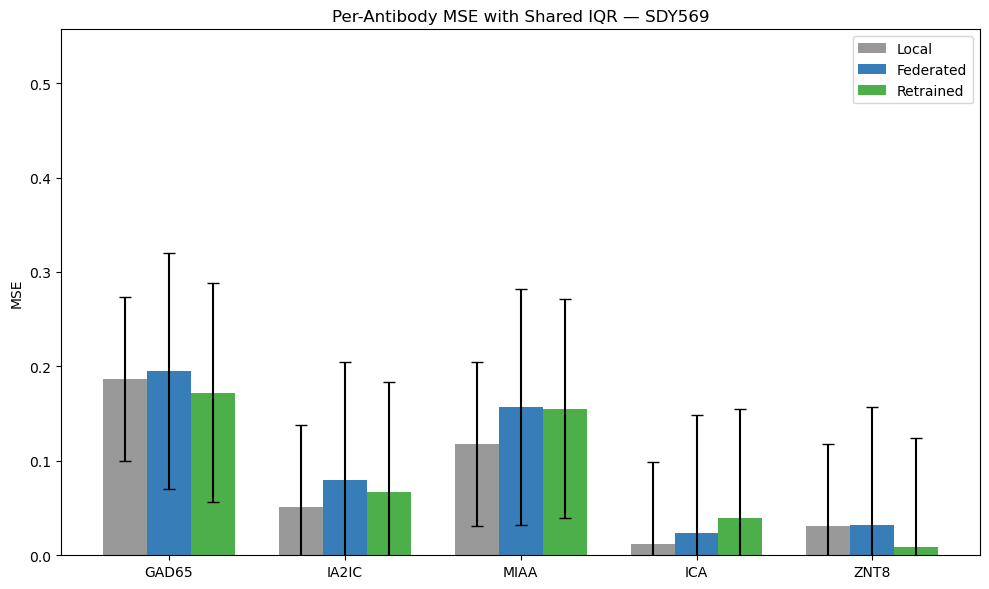

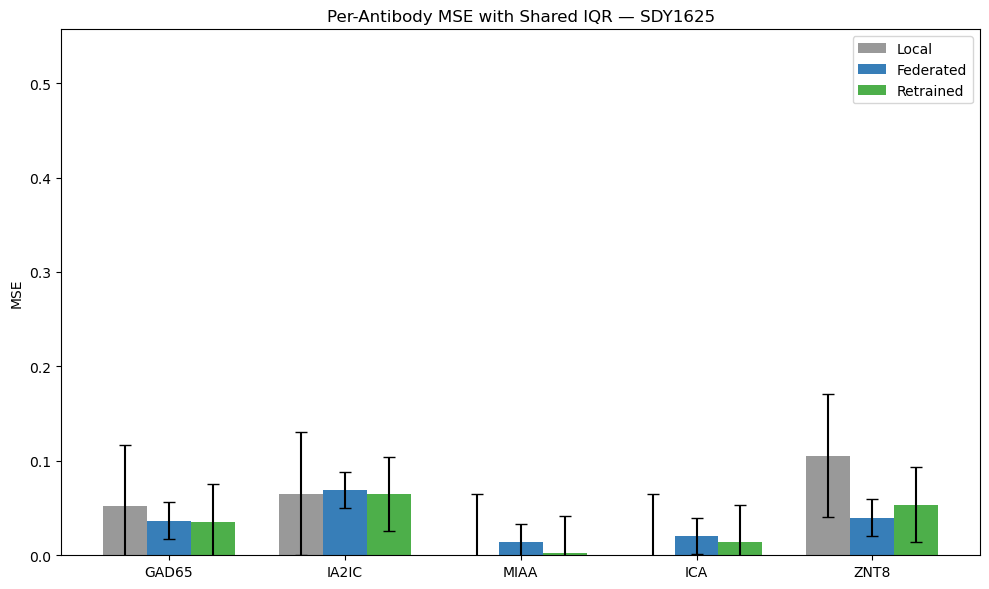

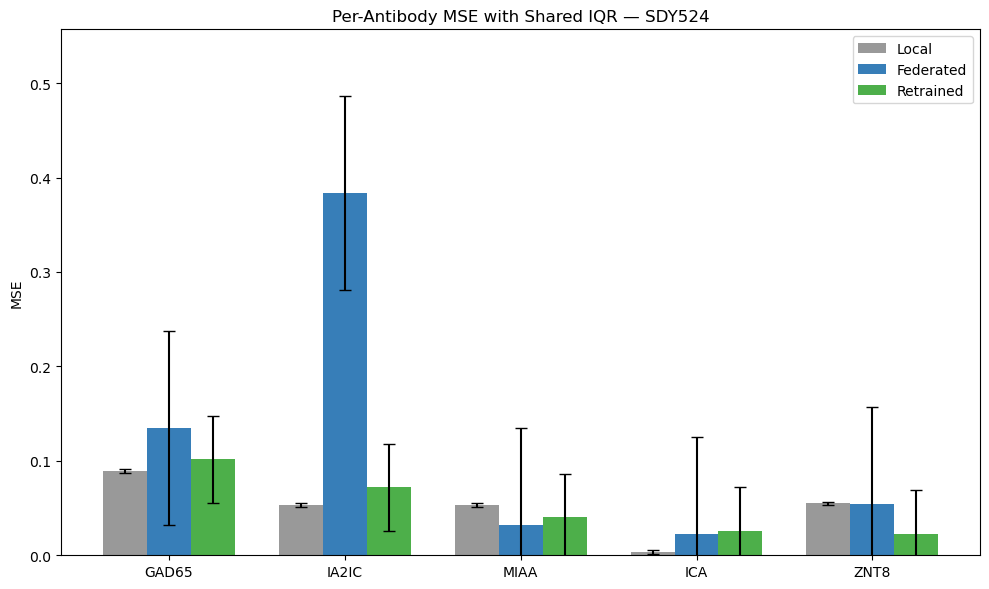

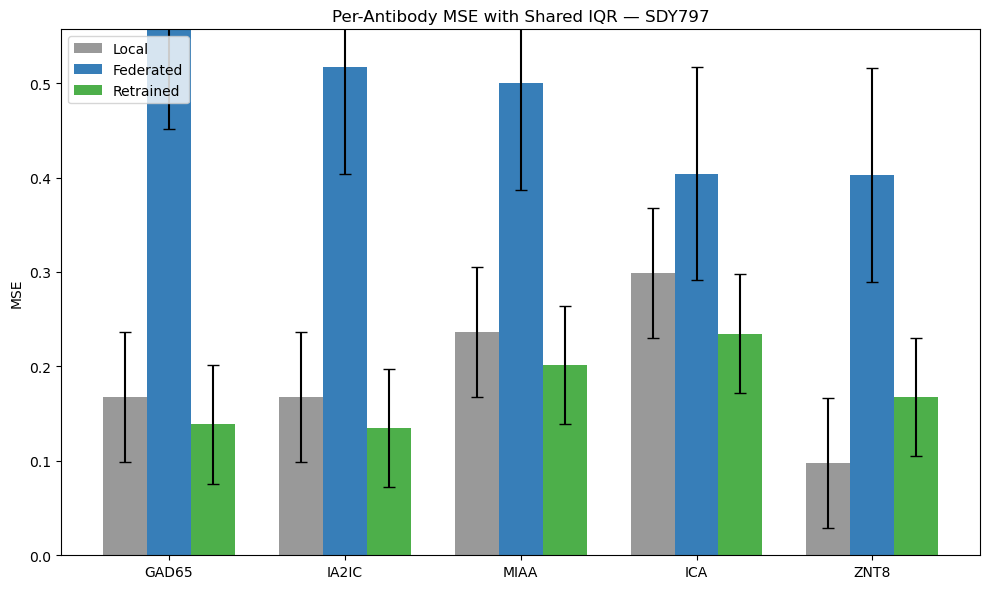

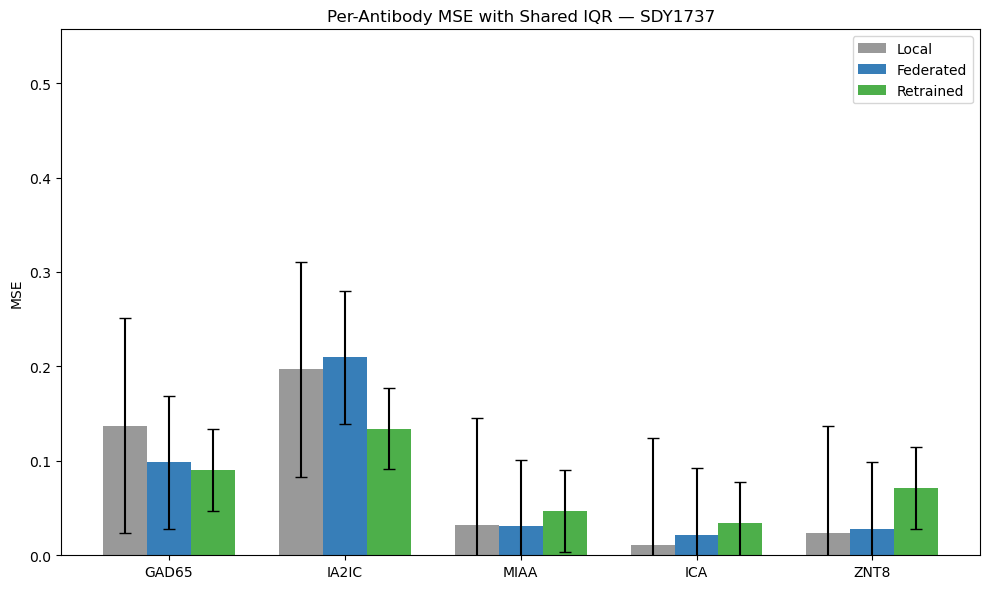

In [35]:
df_ab_iqr = pd.read_csv("results/per_antibody_mse_with_iqr.csv")
plot_per_ab_mse_with_shared_iqr(df_ab_iqr, ymax=ymax)


In [36]:
df_local      = flatten_mse_results(mse_summaries_3x3, model_type="local")
df_federated  = flatten_mse_results(federated_results_3x3, model_type="federated")
df_retrained  = flatten_mse_results(retrained_results_3x3, model_type="retrained")
df_combined   = pd.concat([df_local, df_federated, df_retrained], ignore_index=True)


/var/folders/f4/f7f3s6113490h0n3lsrlqyqh0000gn/T/ipykernel_80193/2384404618.py:4: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_combined   = pd.concat([df_local, df_federated, df_retrained], ignore_index=True)


In [37]:
import matplotlib.pyplot as plt
import numpy as np

def plot_study_level_mse_with_iqr(df, ymax=None):
    model_order = ["local", "federated", "retrained"]
    model_colors = {"local": "#999999", "federated": "#377eb8", "retrained": "#4daf4a"}
    studies = df["Study"].unique()

    for study in studies:
        df_study = df[df["Study"] == study]

        plt.figure(figsize=(6, 5))
        ax = plt.gca()
        x = np.arange(len(model_order))
        bar_width = 0.6

        mse_medians = []
        mse_iqrs = []

        for model in model_order:
            row = df_study[df_study["Model_Type"] == model]
            if not row.empty:
                mse_medians.append(row["MSE_AB_Median"].values[0])
                mse_iqrs.append(row["MSE_AB_IQR"].values[0])
            else:
                mse_medians.append(0)
                mse_iqrs.append(0)

        ax.bar(
            x,
            mse_medians,
            yerr=mse_iqrs,
            capsize=6,
            width=bar_width,
            color=[model_colors[m] for m in model_order],
            tick_label=[m.capitalize() for m in model_order],
        )

        ax.set_ylabel("Median MSE (5 autoantibodies)")
        ax.set_title(f"{study} — Study-level MSE with IQR")
        
        if ymax:
            ax.set_ylim(0, ymax)

        plt.tight_layout()
        plt.show()



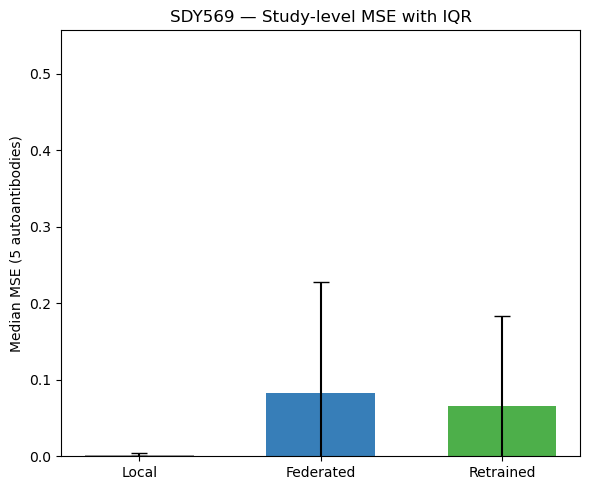

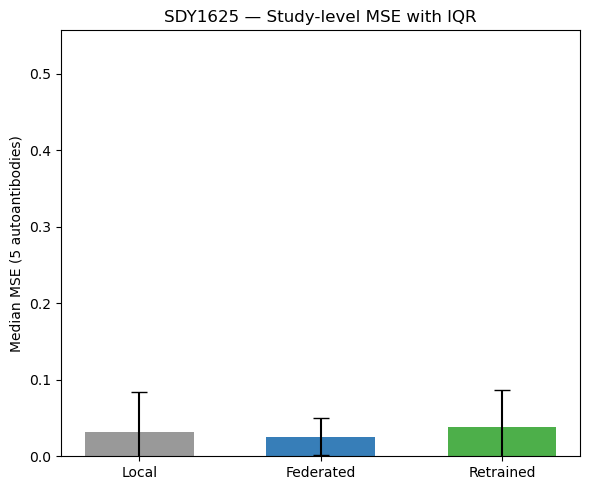

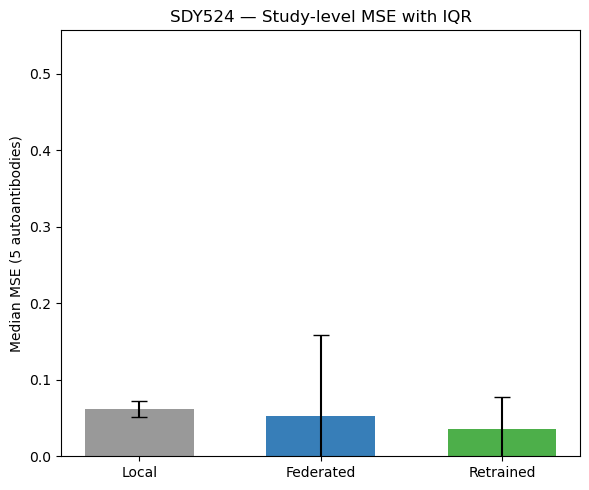

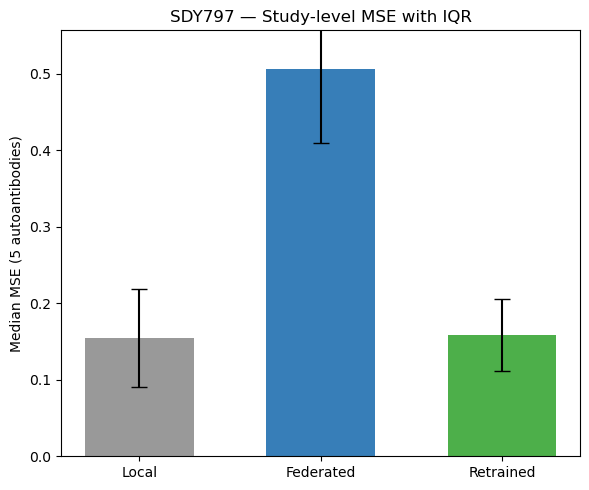

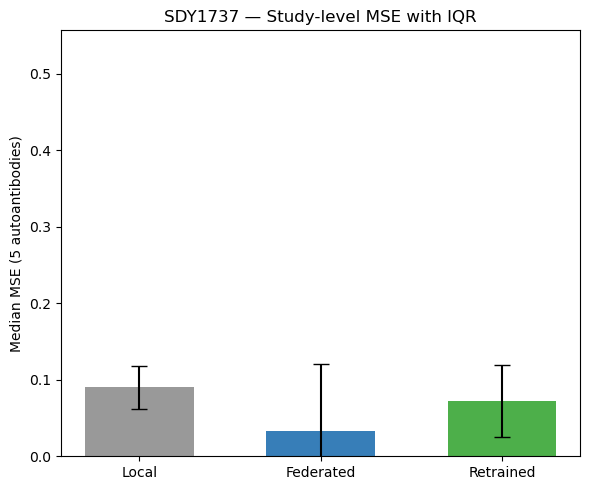

,Study,Model_Type,N_test,MSE_AB_Median,MSE_AB_IQR,MSE_AgeGroup_Median,MSE_AgeGroup_IQR,MSE_Sex_Median,MSE_Sex_IQR,MSE_GAD65,MSE_IA2IC,MSE_MIAA,MSE_ICA,MSE_ZNT8
0,SDY569,local,2,0.002212,0.001458,0.078381,0.055100,0.078381,0.055100,0.383786,0.001126,0.003120,0.002212,0.001663
1,SDY1625,local,6,0.031500,0.052125,0.092801,0.000000,0.092801,0.054651,0.018312,0.336040,0.031500,0.007718,0.070437
2,SDY524,local,15,0.061601,0.010820,0.060427,0.013678,0.049323,0.014162,0.052278,0.061601,0.063098,0.000959,0.092283
3,SDY797,local,10,0.154560,0.063786,0.161972,0.000000,0.171307,0.015558,0.199120,0.105949,0.135333,0.214899,0.154560
4,SDY1737,local,4,0.089968,0.027909,0.080365,0.001609,0.070317,0.020097,0.093402,0.115584,0.065493,0.037377,0.089968
5,SDY569,federated,5,0.082503,0.145420,0.110588,0.059656,0.087557,0.055499,0.215792,0.082503,0.164034,0.012340,0.018614
6,SDY1625,federated,14,0.025731,0.024393,0.028592,0.000000,0.028592,0.007726,0.034786,0.063044,0.009009,0.010393,0.025731
7,SDY524,federated,38,0.052629,0.106290,0.117947,0.041464,0.120549,0.002123,0.140283,0.365080,0.033993,0.012438,0.052629
8,SDY797,federated,25,0.506306,0.097278,0.490907,0.000000,0.479828,0.021304,0.599171,0.506306,0.514700,0.416936,0.417421
9,SDY1737,federated,8,0.032408,0.088798,0.089534,0.039975,0.074098,0.024204,0.107480,0.200222,0.032408,0.011699,0.018681


In [38]:
plot_study_level_mse_with_iqr(df_combined, ymax=ymax)
df_combined.drop(columns=["MSE_All"], inplace=True)
df_combined.to_csv("results/mse_summary_local_vs_federated.csv", index=False)
(df_combined)